Introduction 

In [9]:
import yfinance as yf
import talib
import numpy as np 
import pandas as pd 
import vectorbt as vbt 
import warnings
from scipy import stats 
import matplotlib.pyplot as plt

In [10]:
#Download stock data from 2018 using yfinance

#Change these variable when needed
TICKER = "BTC-USD" #Ticker symbol (e.g. "QQQ", "SPY", "GLD")
START_DATE = "2018-01-01" #Start date (YYYY-MM-DD) format

#Download data from start date to today
stock_data = yf.download(TICKER, start=START_DATE, interval="1d")

#check if data was downloaded successfully (not empty)
if not stock_data.empty:
    print(f"Successfully downloaded {len(stock_data)} records for {TICKER} from {START_DATE} to today")
    print(f"Data range: {stock_data.index.min().date()} to {stock_data.index.max().date()}")
    print(stock_data.head())
else:
    print(f"Failed to download data for {TICKER} from yfinance")

#Display downloaded data
stock_data

[*********************100%***********************]  1 of 1 completed

Successfully downloaded 2924 records for BTC-USD from 2018-01-01 to today
Data range: 2018-01-01 to 2026-01-02
Price              Close          High           Low          Open  \
Ticker           BTC-USD       BTC-USD       BTC-USD       BTC-USD   
Date                                                                 
2018-01-01  13657.200195  14112.200195  13154.700195  14112.200195   
2018-01-02  14982.099609  15444.599609  13163.599609  13625.000000   
2018-01-03  15201.000000  15572.799805  14844.500000  14978.200195   
2018-01-04  15599.200195  15739.700195  14522.200195  15270.700195   
2018-01-05  17429.500000  17705.199219  15202.799805  15477.200195   

Price            Volume  
Ticker          BTC-USD  
Date                     
2018-01-01  10291200000  
2018-01-02  16846600192  
2018-01-03  16871900160  
2018-01-04  21783199744  
2018-01-05  23840899072  


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2018-01-01,13657.200195,14112.200195,13154.700195,14112.200195,10291200000
2018-01-02,14982.099609,15444.599609,13163.599609,13625.000000,16846600192
2018-01-03,15201.000000,15572.799805,14844.500000,14978.200195,16871900160
2018-01-04,15599.200195,15739.700195,14522.200195,15270.700195,21783199744
2018-01-05,17429.500000,17705.199219,15202.799805,15477.200195,23840899072
...,...,...,...,...,...
2025-12-29,87138.140625,90299.156250,86717.914062,87835.789062,48411625849
2025-12-30,88430.132812,89297.937500,86735.546875,87134.351562,35586356225


In [11]:
#Technical analysis indicators using talib

#Make sure stock_data is available from previous cell
if "stock_data" not in locals():
    raise ValueError("stock_data is not defined. Please run the previous cell first.")

#EXTRACT OHLCV data 
# yfinance returns either:
# 1) MultiIndex columns when multiple tickers are downloaded, e.g. ("Close", "QQQ")
# 2) Single-level columns when a single ticker is downloaded, e.g. "Close"
#
# This block handles both cases and extracts OHLCV data
# as NumPy arrays (open_, high, low, close, volume),
# which are required inputs for TA-Lib indicator functions.

if isinstance(stock_data.columns, pd.MultiIndex):
    # MultiIndex case
    open_ = stock_data["Open", TICKER].values
    high = stock_data["High", TICKER].values
    low = stock_data["Low", TICKER].values
    close = stock_data["Close", TICKER].values
    volume = stock_data["Volume", TICKER].values
else:
    # Single-level case
    open_ = stock_data["Open"].values
    high = stock_data["High"].values
    low = stock_data["Low"].values
    close = stock_data["Close"].values
    volume = stock_data["Volume"].values

    print(f"Calculating technical indicators using TA-Lib for {TICKER} from {START_DATE} to today")

#first calculate simple moving averages (SMA)
#defines the trend
sma_20 = talib.SMA(close, timeperiod=20)
sma_50 = talib.SMA(close, timeperiod=50)

#Exponential moving averages (EMA)
#good for signal timing, time the trend
ema_12 = talib.EMA(close, timeperiod=12)
ema_26 = talib.EMA(close, timeperiod=26)

#Moving average convergence divergence (MACD) 
#shows whether momentum is increasing or decreasing by comparing fast and slow trends
macd, macd_signal, macd_hist = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)

#RSI (Relative Strength Index)
#RSI shows whether recent momentum is stretched, not whether price is cheap or expensive
rsi = talib.RSI(close, timeperiod=14)

#Stochastic RSI
#shows how extreme RSI is relative to its recent range, making it a fast timing tool—not a trend indicator
stochrsi_k, stochrsi_d = talib.STOCHRSI(close, timeperiod=14, fastk_period=3, fastd_period=3, fastd_matype=0)

#VWAP (Volume Weighted Average Price)
#the volume-weighted average price up to the current point
#where high-volume trades influence the average more than low-volume trades.
typical_price = (high + low + close) / 3
price_volume = typical_price * volume
cumulative_price_volume = np.cumsum(price_volume)
cumulative_volume = np.cumsum(volume)
vwap = cumulative_price_volume / cumulative_volume

#schaff trend cycle (STC)
#STC turns MACD into a fast, normalized momentum cycle that highlights trend accelerations and slowdowns earlier than MACD alone
cycle_period = 10

# Smooth MACD to reduce noise
macd_cycle = talib.EMA(macd, timeperiod=cycle_period)
macd_smooth = talib.EMA(macd_cycle, timeperiod=cycle_period)

# Find recent high and low of the smoothed MACD
highest_macd = talib.MAX(macd_smooth, timeperiod=cycle_period)
lowest_macd = talib.MIN(macd_smooth, timeperiod=cycle_period)

# Scale MACD into a 0–100 range 
stc_k = 100 * (macd_smooth - lowest_macd) / (highest_macd - lowest_macd) #stochastic k

# Smooth the cycle for cleaner signals
stc_d = talib.EMA(stc_k, timeperiod=3) 

# Unpack Stochastic RSI (returns fastk and fastd)

indicators_df = pd.DataFrame({
    "Date": stock_data.index,
    "Close": close,
    "SMA_20": sma_20,
    "SMA_50": sma_50,
    "EMA_12": ema_12,
    "EMA_26": ema_26,
    "MACD": macd,
    "MACD_Signal": macd_signal,
    "MACD_Hist": macd_hist,
    "RSI": rsi,
    "StochRSI_K": stochrsi_k,
    "StochRSI_D": stochrsi_d,
    "VWAP": vwap,
    "STC_K": stc_k,
    "STC_D": stc_d
})

print("All technical indicators calculated!")
print(f"Data shape: {indicators_df.shape}")
indicators_df.tail(5)

All technical indicators calculated!
Data shape: (2924, 15)


,Date,Close,SMA_20,SMA_50,EMA_12,EMA_26,MACD,MACD_Signal,MACD_Hist,RSI,StochRSI_K,StochRSI_D,VWAP,STC_K,STC_D
2919,2025-12-29,87138.140625,88252.201563,90490.558125,87783.661526,88901.833349,-1118.171823,-1326.604938,208.433114,42.401671,0.000000,66.666667,50849.029233,100.0,99.999998
2920,2025-12-30,88430.132812,88072.660937,90139.228906,87883.118647,88866.892569,-983.773922,-1258.038735,274.264813,47.866453,100.000000,66.666667,50864.071610,100.0,99.999999
2921,2025-12-31,87508.828125,87822.535547,89829.456094,87825.535490,88766.295203,-940.759713,-1194.582930,253.823217,44.615736,40.515166,46.838389,50878.265399,100.0,100.000000
2922,2026-01-01,88731.984375,87745.614062,89570.832031,87964.989164,88763.753660,-798.764495,-1115.419243,316.654748,49.517497,100.000000,80.171722,50886.255421,100.0,100.000000
2923,2026-01-02,89214.679688,87691.412500,89361.175781,88157.249245,88797.155588,-639.906343,-1020.316663,380.410320,51.347479,100.000000,80.171722,50898.280615,100.0,100.000000


In [12]:
#prepare price series 
#we need to split the data into training and testing data (in sample and out of sample)
#for robustness our ratio of IS to OOS will be 60/40 or 70/30
#suppress warnings from appearing in the output
warnings.filterwarnings("ignore", message="Degrees of freedom <= 0 for slice", category=RuntimeWarning)
warnings.filterwarnings("ignore", message="invalid value encountered in scalar divide", category=RuntimeWarning)

# Function to extract the 'Close' price series from a DataFrame
# This function handles different DataFrame column structures (MultiIndex vs single-level)
# Expect stock_data and TICKER already exist from previous cells
def select_close_series(df, ticker):
    """
    Extracts the 'Close' price column from a DataFrame, handling both MultiIndex and single-level columns.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The stock data DataFrame (from yfinance)
    ticker : str
        The ticker symbol (e.g., "BTC-USD", "QQQ")
    
    Returns:
    --------
    pandas.Series
        The Close price series as a float Series
    """
    # Check if DataFrame has MultiIndex columns (happens when downloading multiple tickers)
    if isinstance(df.columns, pd.MultiIndex):
        # Try to select the Close column for the specific ticker
        if ("Close", ticker) in df.columns:
            s = df[("Close", ticker)]
        else:
            # If ticker-specific column not found, search for any column containing 'Close'
            cols = [c for c in df.columns if 'Close' in str(c)]
            if not cols:
                raise KeyError("Close not found")
            s = df[cols[0]]
    else:
        # Single-level columns case - search for any column containing 'Close'
        cols = [c for c in df.columns if 'Close' in str(c)]
        if not cols:
            raise KeyError("Close not found")
        s = df[cols[0]]
    
    # Convert to float and squeeze to ensure it's a 1D Series (remove any extra dimensions)
    return s.astype(float).squeeze()

# Extract the Close price series using our function
# This gives us a clean pandas Series with just the closing prices
close = select_close_series(stock_data, TICKER)

# Rename the series to 'price' for clarity in subsequent analysis
close.name = 'price'

# Simple split: Divide data into training and validation sets
# TRAIN_RATIO determines what percentage of data is used for training
# 0.6 means 60% training, 40% validation
TRAIN_RATIO = 0.6

# Calculate the index where we'll split the data
# int() truncates to ensure we get a valid integer index
split_idx = int(len(close) * TRAIN_RATIO)

# Create training set: all data from the beginning up to split_idx
# .copy() ensures we get an independent copy, not a view
train_close = close.iloc[:split_idx].copy()

# Create validation set: all data from split_idx to the end
# This is our out-of-sample data for testing model performance
val_close = close.iloc[split_idx:].copy()

# Print the date ranges for both datasets to verify the split
# This helps us understand what time periods we're training and validating on
print(f"Data ready: train={train_close.index[0].date()} → {train_close.index[-1].date()} | val={val_close.index[0].date()} → {val_close.index[-1].date()}")

Data ready: train=2018-01-01 → 2022-10-20 | val=2022-10-21 → 2026-01-02


## TRIPLE EMA CROSSOVER GRID SEARCH - TRAINING SET

This section performs a comprehensive grid search optimization for the **Triple EMA Crossover Strategy** using only the **training data**.

The goal is to find the optimal EMA1/EMA2/EMA3 combination that maximizes the Sharpe ratio on OOS data.

**Strategy Logic:** Buy when any EMA crosses above another (EMA1 > EMA2, EMA1 > EMA3, or EMA2 > EMA3). Sell when any EMA crosses below another.

In [13]:
# Define Parameter Ranges for Triple EMA Crossover
# EMA periods for triple crossover strategy
ema1_periods = list(range(4, 40, 1))   # Fast EMA (shortest-term)
ema2_periods = list(range(50, 90, 2))  # Medium EMA (medium-term)
ema3_periods = list(range(120, 250, 3)) # Slow EMA (longest-term)

print("EMA1 Periods (fast - shortest-term):")
for i, period in enumerate(ema1_periods, 1):
    print(f" {i}. {period} periods")

print("EMA2 Periods (medium - medium-term):")
for i, period in enumerate(ema2_periods, 1):
    print(f" {i}. {period} periods")

print("EMA3 Periods (slow - longest-term):")
for i, period in enumerate(ema3_periods, 1):
    print(f" {i}. {period} periods")

# Generate all valid combinations (ema1 < ema2 < ema3)
ema_combinations = []
for ema1 in ema1_periods:
    for ema2 in ema2_periods:
        for ema3 in ema3_periods:
            if ema1 < ema2 < ema3:
                ema_combinations.append((ema1, ema2, ema3))

print(f"Generated {len(ema_combinations)} valid Triple EMA combinations")
print("\n First 10 combinations preview:")
for i, (ema1, ema2, ema3) in enumerate(ema_combinations[:10], 1):
    print(f" {i:2d}. EMA1: {ema1:2d} | EMA2: {ema2:2d} | EMA3: {ema3:2d}")
if len(ema_combinations) > 10:
    print(f" ... and {len(ema_combinations) - 10} more combinations")

print("Ready to test all combinations on training data!")

EMA1 Periods (fast - shortest-term):
 1. 4 periods
 2. 5 periods
 3. 6 periods
 4. 7 periods
 5. 8 periods
 6. 9 periods
 7. 10 periods
 8. 11 periods
 9. 12 periods
 10. 13 periods
 11. 14 periods
 12. 15 periods
 13. 16 periods
 14. 17 periods
 15. 18 periods
 16. 19 periods
 17. 20 periods
 18. 21 periods
 19. 22 periods
 20. 23 periods
 21. 24 periods
 22. 25 periods
 23. 26 periods
 24. 27 periods
 25. 28 periods
 26. 29 periods
 27. 30 periods
 28. 31 periods
 29. 32 periods
 30. 33 periods
 31. 34 periods
 32. 35 periods
 33. 36 periods
 34. 37 periods
 35. 38 periods
 36. 39 periods
EMA2 Periods (medium - medium-term):
 1. 50 periods
 2. 52 periods
 3. 54 periods
 4. 56 periods
 5. 58 periods
 6. 60 periods
 7. 62 periods
 8. 64 periods
 9. 66 periods
 10. 68 periods
 11. 70 periods
 12. 72 periods
 13. 74 periods
 14. 76 periods
 15. 78 periods
 16. 80 periods
 17. 82 periods
 18. 84 periods
 19. 86 periods
 20. 88 periods
EMA3 Periods (slow - longest-term):
 1. 120 periods
 2

In [14]:
# Create Triple EMA Results Collection System

# Create empty list to store all backtest results
grid_search_results = []

print("Triple EMA Results Collection System Initialized")
# Note: 'ema_combinations' variable must exist from the previous step
print(f" - Will test {len(ema_combinations)} Triple EMA combinations")
print(" - Results will be stored in 'grid_search_results' list")

# Define what metrics we will collect (All TradingView-style metrics)
metrics_to_collect = [
    # Strategy Parameters
    "ema1_period",
    "ema2_period",
    "ema3_period",

    # Return Metrics
    "total_return",         # The total percentage gain or loss over the entire backtest period
    "annualized_return",    # The geometric average return calculated on a yearly basis (CAGR)
    "total_profit",         # The absolute monetary value gained (Net Profit)

    # Risk-Adjusted Return Metrics
    "sharpe_ratio",         # Return divided by volatility. Measures how much return you get per unit of risk
    "sortino_ratio",        # Similar to Sharpe, but only penalizes "bad" (downside) volatility
    "calmar_ratio",         # Annualized Return divided by Maximum Drawdown. Measures return relative to the worst run of trades
    "omega_ratio",          # Probability-weighted ratio of gains versus losses (captures the entire distribution)
    "information_ratio",    # Active return (vs benchmark) divided by tracking error (volatility of active return)
    "tail_ratio",           # Ratio of the 95th percentile of gains to the 95th percentile of losses (measures outliers)
    "deflated_sharpe_ratio",# Adjusts the Sharpe Ratio to account for the probability of finding a good result by luck (multiple testing bias)


    # Risk Metrics
    "max_drawdown",         # The largest percentage drop from a peak to a trough (worst-case scenario).
    "volatility",           # Standard deviation of returns; measures how wildly prices swing.
    "ulcer_index",          # Measures the depth and duration of drawdowns (stress indicator).

    # Trade Performance Metrics
    "win_rate",             # Percentage of trades that were profitable.
    "total_trades",         # The total count of trades executed during the backtest.
    "avg_trade_duration",   # The average amount of time a trade is held open.
    "expectancy",           # The average amount of money you can expect to make (or lose) per trade.
    "profit_factor",        # Gross Profit divided by Gross Loss. (>1 is profitable, >1.5 is good).
    "sqn",                  # System Quality Number; measures the relationship between expectancy and the standard deviation of results.

    # Win/Loss Analysis
    "payoff_ratio",         # Average Win Amount divided by Average Loss Amount.
    "largest_win",          # The single biggest profit from one trade.
    "largest_loss",         # The single biggest loss from one trade.
    "avg_win_amount",       # The average profit of all winning trades.
    "avg_loss_amount",      # The average loss of all losing trades.
    "winning_streak",       # The maximum number of consecutive winning trades.
    "losing_streak",        # The maximum number of consecutive losing trades.

    # Additional Ratios
    "recovery_factor",      # Net Profit divided by Max Drawdown (how fast the strategy recovers from losses).
    "gain_to_pain_ratio",   # Sum of all returns divided by the absolute value of all negative returns.
    "serenity_index"        # A risk-adjusted return metric that penalizes volatility and drawdowns heavily.
]

print("Metrics to collect for each Triple EMA combination:")
for i, metric in enumerate(metrics_to_collect, 1):
    print(f" {i}. {metric.replace('_', ' ').title()}")

print("Ready to start the Triple EMA grid search!")




Triple EMA Results Collection System Initialized
 - Will test 31680 Triple EMA combinations
 - Results will be stored in 'grid_search_results' list
Metrics to collect for each Triple EMA combination:
 1. Ema1 Period
 2. Ema2 Period
 3. Ema3 Period
 4. Total Return
 5. Annualized Return
 6. Total Profit
 7. Sharpe Ratio
 8. Sortino Ratio
 9. Calmar Ratio
 10. Omega Ratio
 11. Information Ratio
 12. Tail Ratio
 13. Deflated Sharpe Ratio
 14. Max Drawdown
 15. Volatility
 16. Ulcer Index
 17. Win Rate
 18. Total Trades
 19. Avg Trade Duration
 20. Expectancy
 21. Profit Factor
 22. Sqn
 23. Payoff Ratio
 24. Largest Win
 25. Largest Loss
 26. Avg Win Amount
 27. Avg Loss Amount
 28. Winning Streak
 29. Losing Streak
 30. Recovery Factor
 31. Gain To Pain Ratio
 32. Serenity Index
Ready to start the Triple EMA grid search!


In [15]:
# TRIPLE EMA CROSSOVER GRID SEARCH ON TRAINING DATA

print("INITIATING TRIPLE EMA CROSSOVER GRID SEARCH OPTIMIZATION")
print("=" * 70)
print(f"Testing Strategy: Triple Exponential Moving Average Crossover")
print(f"Training Period: {train_close.index[0].date()} -> {train_close.index[-1].date()}")
print(f"Initial Capital: $100,000")
print(f"Transaction Costs: 0.05% per trade (fees + slippage)")
print(f"Optimization Metric: Sharpe Ratio (risk-adjusted returns)")
print("=" * 70)

# Ensure results container exists
if 'grid_search_results' not in locals():
    grid_search_results = []

total_combinations = len(ema_combinations)
successful_tests = 0
failed_tests = 0

print(f"Starting grid search across {total_combinations} parameter combos... \n")

# Iterate through every combination of EMA periods we generated earlier
# 'enumerate(..., 1)' starts the counter 'i' at 1 instead of 0
for i, (ema1_period, ema2_period, ema3_period) in enumerate(ema_combinations, 1):
    try:
        # --- 1. INDICATORS ---
        # Calculate the 3 EMA lines for the current combination using VectorBT
        # ewm=True ensures it calculates an Exponential Moving Average (not Simple)
        ema1 = vbt.MA.run(train_close, ema1_period, ewm=True)
        ema2 = vbt.MA.run(train_close, ema2_period, ewm=True)
        ema3 = vbt.MA.run(train_close, ema3_period, ewm=True)

        # --- 2. SIGNALS (LOGIC) ---
        # BUY LOGIC (Entry):
        # We buy if ANY of the faster EMAs cross above a slower EMA.
        # The '|' operator means "OR".
        entries_raw = (
            ema1.ma_crossed_above(ema2.ma) |  # Fast crosses above Medium
            ema1.ma_crossed_above(ema3.ma) |  # Fast crosses above Slow
            ema2.ma_crossed_above(ema3.ma)    # Medium crosses above Slow
        )

        # SELL LOGIC (Exit):
        # We sell if ANY of the faster EMAs cross below a slower EMA.
        exits_raw = (
            ema1.ma_crossed_below(ema2.ma) |  # Fast crosses below Medium
            ema1.ma_crossed_below(ema3.ma) |  # Fast crosses below Slow
            ema2.ma_crossed_below(ema3.ma)    # Medium crosses below Slow
        )

        # --- 3. DATA CLEANING ---
        # Clean up the signals to ensure they are simple 1D Boolean Series (True/False)
        # VectorBT sometimes returns complex structures; this forces them into a standard list format
        # compatible with the portfolio simulation engine.
        entries = pd.Series(np.asarray(entries_raw).ravel(), index=train_close.index, dtype=bool)
        exits   = pd.Series(np.asarray(exits_raw).ravel(),   index=train_close.index, dtype=bool)

        # --- 4. BACKTEST SIMULATION ---
        # Run the portfolio simulation using vectorbt's engine
        portfolio = vbt.Portfolio.from_signals(
            
            # The Data
            close=train_close,    #The price array used to execute trades. Price to pay
            
            # The Signals
            entries=entries,      # A list of True/False values. True = "Buy/Open a position right now".
            exits=exits,          # A list of True/False values. True = "Sell/Close the position right now".
            
            # The Money
            init_cash=100_000,    # We start the simulation with $100k virtual cash.
            
            # Realism Parameters (Crucial!)
            # 0.0005 = 0.05%. We pay this fee on EVERY trade (buy and sell). 
            # add this! high-frequency strategies will look fake/profitable when they aren't.
            fees=0.0005,
            
            # 0.0005 = 0.05%. This simulates "bad luck" in execution.
            # accounts for the spread and market movement.
            slippage=0.0005,
            
            # Time Settings
            # "D" tells vectorbt that our data is Daily.
            # This is required to correctly calculate Annualized Return and Sharpe Ratio.
            freq="D"
        )

        # --- 5. CALCULATE PORTFOLIO METRICS ---
        # We wrap values in float() to ensure they are standard Python numbers, not complex arrays.
        
        # Basic Performance Metrics
        total_return = float(portfolio.total_return())
        
        # 'freq="D"' is CRITICAL here. It tells the system to scale the return to a yearly basis (Annualized).
        annualized_return = float(portfolio.annualized_return(freq='D'))
        
        # Max Drawdown: The worst percentage drop from a peak. (e.g., -0.20 means a 20% crash)
        max_drawdown = float(portfolio.max_drawdown())
        
        # Volatility: How 'bumpy' the ride is. Higher = riskier.
        volatility = float(portfolio.annualized_volatility(freq='D'))
        
        # Sharpe Ratio: Reward per unit of risk. > 1.0 is generally good.
        sharpe_ratio = float(portfolio.sharpe_ratio(freq='D'))
        
        # Sortino Ratio: Like Sharpe, but only penalizes 'bad' volatility (downside crashes).
        sortino_ratio = float(portfolio.sortino_ratio(freq='D'))

        # --- ADVANCED METRICS (Safe Mode) ---
        # These complex metrics can sometimes crash (e.g., if there are 0 trades or flat returns).
        # We use try/except blocks to set them to "NaN" (Not a Number) instead of crashing the whole script.

        try:
            # Information Ratio: Returns relative to a benchmark. 
            information_ratio = float(portfolio.information_ratio(freq='D'))
        except Exception:
            information_ratio = np.nan

        try:
            # Tail Ratio: Measures extreme wins vs extreme losses (outlier analysis).
            tail_ratio = float(portfolio.tail_ratio(freq='D'))
        except Exception:
            tail_ratio = np.nan

        try:
            # Deflated Sharpe: Adjusts Sharpe for "p-hacking" (finding a strategy by luck/over-testing).
            deflated_sharpe_ratio = float(portfolio.deflated_sharpe_ratio(freq='D'))
        except Exception:
            deflated_sharpe_ratio = np.nan

        # --- ULCER INDEX CALCULATION ---
        # The Ulcer Index measures the "stress" of holding an asset.
        # It penalizes both the DEPTH of a crash and how LONG it takes to recover.
        # Since VectorBT might not have a direct function for this, we calculate it manually:
        
        returns = portfolio.returns()
        cum = (1 + returns).cumprod()      # Calculate cumulative growth curve
        peak = cum.cummax()                # Track the "all-time high" at every point
        dd = (cum - peak) / peak           # Calculate drawdown percentage
        
        # Formula: Square Root of the Mean of Squared Drawdowns
        ulcer_index = float(np.sqrt((dd.pow(2)).mean())) if len(dd) else np.nan

        # --- 6. TRADE METRICS ---
        # Get the list of all individual trades executed
        trades = portfolio.trades
        
        # Count total number of completed trades
        total_trades = int(len(trades))
        
        # Initialize these variables with placeholders (NaN or 0.0).
        # We will calculate the actual values in the next block.
        win_rate_pct = np.nan
        profit_factor = np.nan
        expectancy = 0.0
        avg_win_amount = 0.0
        avg_loss_amount = 0.0
        # --- 7. WIN/LOSS ANALYSIS ---
        # We only run this logic if the strategy actually made trades. 
        # If total_trades is 0, we skip this to avoid "Division by Zero" errors.
        if total_trades > 0:
    
         # Extract the returns (profit/loss %) for every individual trade.
            # We use 'hasattr' to check if the data is a Pandas Series or a Numpy array 
            # and handle it correctly to prevent format errors.
            tr = trades.returns.values if hasattr(trades.returns, 'values') else np.array(trades.returns)

            # Double check that the returns array isn't empty
            if tr.size > 0:
                # Separate the trades into two piles: Winners (Positive) and Losers (Negative)
                pos = tr[tr > 0]
                neg = tr[tr < 0]

                # Win Rate: The percentage of trades that were profitable.
             # Formula: (Count of Winners / Total Count of Trades) * 100
                win_rate_pct = (len(pos) / len(tr)) * 100.0

                # Calculate Total Gross Profit (Sum of all wins)
                gains = pos.sum() if len(pos) else 0.0

                # Calculate Total Gross Loss (Sum of all losses, absolute value)
                losses = abs(neg.sum()) if len(neg) else 0.0
        
                # Profit Factor: The "Gold Standard" metric for strategy robustness.
                # Formula: Gross Profit / Gross Loss. 
                # > 1.5 is usually good. > 3.0 is excellent.
                # If we have 0 losses (perfect strategy), we set it to Infinity (np.inf).
                profit_factor = (gains / losses) if losses > 0 else np.inf

                # Expectancy: The average percent return you can expect per trade.
                expectancy = float(tr.mean())

                # Average Win vs Average Loss
                # This tells us the "Payoff Ratio" later. Ideally, Avg Win > Avg Loss.
                avg_win_amount = float(pos.mean()) if len(pos) else 0.0
                avg_loss_amount = float(abs(neg.mean())) if len(neg) else 0.0

        # --- 7. FREQUENCY & STABILITY ANALYSIS ---
        
        # Calculate the total duration of the backtest in years.
        # We subtract the last date from the first date to get days, then divide by 365.25.
        # "1e-9" is a safety hack: if the data is empty, we divide by this tiny number 
        # instead of 0 to avoid a "ZeroDivisionError" crash.
        years = max((train_close.index[-1] - train_close.index[0]).days / 365.25, 1e-9)
        
        # Trades Per Year: This tells us how active the strategy is.
        trades_per_year = total_trades / years

        # --- 8. QUALITY FILTER ("The Soft Skip") ---
        # This is a critical step for optimization speed and quality.
        # If a strategy trades less than 2 times a year, it is not statistically significant.
        # We "continue" (skip) immediately, ignoring this combination and moving to the next one.
        if trades_per_year < 2:
            continue

        # --- 9. ADVANCED RATIOS ---
        
        # Payoff Ratio: (Avg Win / Avg Loss).
        # Measures if your wins are big enough to cover your losses.
        # We check "if avg_loss_amount not in (0.0, np.nan)" to avoid dividing by zero.
        payoff_ratio = (avg_win_amount / avg_loss_amount) if avg_loss_amount not in (0.0, np.nan) else np.inf

        # Streaks: Consecutive wins or losses.
        # This helps identify "psychological pain" (e.g., losing 10 times in a row).
        try:
            # vectorbt has built-in functions for this, but they crash if there are 0 trades.
            winning_streak = int(trades.winning_streak())
            losing_streak = int(trades.losing_streak())
        except Exception:
            # If the calculation fails, just set them to "Not a Number" (NaN).
            winning_streak = np.nan
            losing_streak = np.nan
        
        # --- 10. STORE RESULTS ---
        # We append all the calculated metrics for this specific combination into our main list.
        # This builds a "row" of data that we will later turn into DF
        # We use a Dictionary format: {"Column Name": Value}
        grid_search_results.append({
            "ema1_period": ema1_period,
            "ema2_period": ema2_period,
            "ema3_period": ema3_period,
            "total_return": total_return,
            "annualized_return": annualized_return,
            "max_drawdown": max_drawdown,
            "volatility": volatility,
            "sharpe_ratio": sharpe_ratio,
            "sortino_ratio": sortino_ratio,
            "information_ratio": information_ratio,
            "tail_ratio": tail_ratio,
            "deflated_sharpe_ratio": deflated_sharpe_ratio,
            "ulcer_index": ulcer_index,
            "total_trades": total_trades,
            "win_rate": win_rate_pct,
            "profit_factor": profit_factor,
            "expectancy": expectancy,
            "avg_win_amount": avg_win_amount,
            "avg_loss_amount": avg_loss_amount,
            "payoff_ratio": payoff_ratio,
            "winning_streak": winning_streak,
            "losing_streak": losing_streak,
            "trades_per_year": trades_per_year
        })

        # Increment our success counter so we can track valid tests
        successful_tests += 1

        #Get progress (to avoid staring at timer worried)
        if i % 10 == 0 or i == total_combinations:
            progress_pct = (i / total_combinations) * 100
            print(f"Progress: {i}/{total_combinations} ({progress_pct:1f}%)")
            print(f"Successful: {successful_tests} | Failed: {failed_tests}")
            print(f"    Latest: EMA({ema1_period},{ema2_period},{ema3_period}) -> Sharpe: {sharpe_ratio:.1f}, Return: {total_return:.1%}")
            print(f"    Trades: {total_trades}, Win Rate: {win_rate_pct:.1f}%, Max DD: {max_drawdown:.1%}\n")

    # --- 13. ERROR HANDLING ---
    # This block runs ONLY if something crashes inside the "try" block above.
    except Exception as e:
        failed_tests += 1
        
        # We still want to see progress updates even if things are failing.
        # This checks if we are at a "milestone" (every 10th item) or the very last item.
        if i % 10 == 0 or i == total_combinations:
            print(f"Error with EMA({ema1_period},{ema2_period},{ema3_period}): {str(e)[:80]}...")

# --- 14. FINAL SUMMARY ---
# This code runs once the loop has finished checking ALL combinations.
print("\nGRID SEARCH COMPLETED!")

print(f"Total combinations attempted: {total_combinations}")
print(f"Successfully completed: {successful_tests}")
print(f"Failed: {failed_tests}")

# Calculate success rate safely (avoid division by zero if total_combinations is 0)
if total_combinations > 0:
    success_rate = (successful_tests / total_combinations) * 100
    print(f"Success rate: {success_rate:.1f}%")

print("\nResults stored in 'grid_search_results'")


#we get 47.3% success the rest being under desired minimum trades of 2/year



INITIATING TRIPLE EMA CROSSOVER GRID SEARCH OPTIMIZATION
Testing Strategy: Triple Exponential Moving Average Crossover
Training Period: 2018-01-01 -> 2022-10-20
Initial Capital: $100,000
Transaction Costs: 0.05% per trade (fees + slippage)
Optimization Metric: Sharpe Ratio (risk-adjusted returns)
Starting grid search across 31680 parameter combos... 

Progress: 10/31680 (0.031566%)
Successful: 10 | Failed: 0
    Latest: EMA(4,50,147) -> Sharpe: 1.0, Return: 437.6%
    Trades: 30, Win Rate: 33.3%, Max DD: -49.6%

Progress: 20/31680 (0.063131%)
Successful: 20 | Failed: 0
    Latest: EMA(4,50,177) -> Sharpe: 1.1, Return: 553.1%
    Trades: 27, Win Rate: 29.6%, Max DD: -49.6%

Progress: 30/31680 (0.094697%)
Successful: 30 | Failed: 0
    Latest: EMA(4,50,207) -> Sharpe: 1.0, Return: 437.7%
    Trades: 28, Win Rate: 28.6%, Max DD: -52.9%

Progress: 40/31680 (0.126263%)
Successful: 40 | Failed: 0
    Latest: EMA(4,50,237) -> Sharpe: 1.0, Return: 413.9%
    Trades: 29, Win Rate: 27.6%, Max DD

In [16]:
# --- ANALYZE TRIPLE EMA GRID SEARCH RESULTS ---

# Convert the list of results (dictionaries) into a Pandas DataFrame.
results_df = pd.DataFrame(grid_search_results)
print(results_df.head())

print("Grid Search Results Analysis")
print("=" * 50)
print(f"Total combinations tested: {len(results_df)}")
print(f"Results shape: {results_df.shape}")

# --- COMPREHENSIVE STATISTICS ---
print("\nComprehensive Performance Statistics:")
print("-" * 50)

#Return Metrics
# We use .max() to find the single highest number in the column.
# We use .mean() to see how the strategy performs "on average" across all settings.
print("Return Metrics:")
print(f"   Best Total Return: {results_df['total_return'].max():.2%}")
print(f"   Average Total Return: {results_df['total_return'].mean():.2%}")
print(f"   Best Annualized Return: {results_df['annualized_return'].max():.2%}")

#Risk-Adjusted Metrics
print("\nRisk-Adjusted Metrics:")
print(f"   Best Sharpe Ratio: {results_df['sharpe_ratio'].max():.3f}")
print(f"   Best Sortino Ratio: {results_df['sortino_ratio'].max():.3f}")

# --- RISK METRICS ---
print("Risk Metrics:")

# We look at the 'mean' to see if the strategy family is generally risky, 
# and 'min'/'max' to see the extreme outliers.
print(f"   Average Max Drawdown: {results_df['max_drawdown'].mean():.2%}")

# Note: Since drawdowns are usually negative numbers (e.g., -0.20), .min() actually finds 
# the DEEPEST (worst) crash. .max() finds the smallest (best) drawdown.
# This line shows the worst-case scenario across all combinations.
print(f"   Best Max Drawdown: {results_df['max_drawdown'].min():.2%}")

print(f"   Average Volatility: {results_df['volatility'].mean():.2%}")

# --- TRADE PERFORMANCE ---
print("Trade Performance:")

# Win Rate is stored as a float 0-100 (e.g., 55.5), so we use ':.1f}%' formatting.
print(f"   Best Win Rate: {results_df['win_rate'].max():.1f}%") 
print(f"   Average Win Rate: {results_df['win_rate'].mean():.1f}%")

# Profit Factor: Gross Profit / Gross Loss. Higher is better.
print(f"   Best Profit Factor: {results_df['profit_factor'].max():.2f}")

# This gives us a range: Did strategies trade 5 times or 500 times?
print(f"   Total Trades Range: {results_df['total_trades'].min():.0f} - {results_df['total_trades'].max():.0f}")

# --- ADDITIONAL METRICS ---
print("Additional Metrics:")

# Expectancy: The average return per trade.
print(f"   Best Expectancy: {results_df['expectancy'].max():.4f}")

# How active is the strategy on average?
print(f"   Average Trades per Year: {results_df['trades_per_year'].mean():.1f}")

# --- FIND THE WINNER ---
# This is the most critical step.
# .idxmax() scans the 'sharpe_ratio' column and returns the INDEX (Row ID) of the highest value.
# .loc[] then grabs that entire row of data so we can see the parameters.
best_result = results_df.loc[results_df['sharpe_ratio'].idxmax()]

print("BEST STRATEGY (by Sharpe Ratio)")
print("-" * 50)
print(f"EMA1 Period (Fast): {int(best_result['ema1_period'])}")
print(f"EMA2 Period (Medium): {int(best_result['ema2_period'])}")
print(f"EMA3 Period (Slow): {int(best_result['ema3_period'])}")
print(f"Total Return: {best_result['total_return']:.2%}")
print(f"Sharpe Ratio: {best_result['sharpe_ratio']:.3f}")
print(f"Max Drawdown: {best_result['max_drawdown']:.2%}")
print(f"Trades per year: {best_result['trades_per_year']}")

# We use .1f here because Win Rate is stored as 0-100 (e.g., 55.5), not 0.55
print(f"Win Rate: {best_result['win_rate']:.1f}%") 
print(f"Total Trades: {int(best_result['total_trades'])}")

print("\nTop 5 Best Performers:")
# Find the 5 rows with the highest Sharpe Ratio
top_5 = results_df.nlargest(5, "sharpe_ratio")

# Iterate through the top 5 to print a nice leaderboard
# .iterrows() lets us loop through the DataFrame row by row
for i, (_, row) in enumerate(top_5.iterrows(), 1):
    print(f"{i}. EMA({int(row['ema1_period'])},{int(row['ema2_period'])},{int(row['ema3_period'])}) -> Sharpe: {row['sharpe_ratio']:.3f}, Return: {row['total_return']:.1%}")

print("\nAnalysis complete! Best strategy identified.")

   ema1_period  ema2_period  ema3_period  total_return  annualized_return  \
0            4           50          120      4.144487           0.406136   
1            4           50          123      4.144487           0.406136   
2            4           50          126      4.183755           0.408363   
3            4           50          129      4.154241           0.406690   
4            4           50          132      4.305956           0.415208   

   max_drawdown  volatility  sharpe_ratio  sortino_ratio  information_ratio  \
0     -0.510097    0.474514      0.954394       1.458407           0.009636   
1     -0.510097    0.474514      0.954394       1.458407           0.009636   
2     -0.510097    0.474503      0.957745       1.463544           0.009781   
3     -0.510097    0.474511      0.955230       1.459689           0.009672   
4     -0.510097    0.474811      0.967650       1.479481           0.010245   

   ...  total_trades   win_rate  profit_factor  expectancy  av

In [17]:
#NOTICED INCONSISTENCY IN RULES BETWEEN GRID SEARCH AND BENCHMARK ANALYSIS

#Here we check our best strategy with the stricter rules vs. loose rules in gride search
#Loose rules is any faster ema crossing a slower ema to buy/sell
#strict rules ensures trend is robust but can take too few trades and remain in crashing markets


if results_df.empty:
    print("No results to compare to benchmark")
else:
    #retrive the best strategy (highest sharpe here)
    best = results_df.loc[results_df["sharpe_ratio"].idxmax()]
    ema1, ema2, ema3 = int(best["ema1_period"]), int(best["ema2_period"]), int(best["ema3_period"])

# --- STRATEGY SHOWDOWN: LOOSE vs STRICT vs HYBRID ---

print(f"Comparing Strategies for EMA({ema1}, {ema2}, {ema3})")
print("=" * 95)

# 1. CALCULATE INDICATORS (Shared by all)
ema1_ma = vbt.MA.run(train_close, ema1, ewm=True)
ema2_ma = vbt.MA.run(train_close, ema2, ewm=True)
ema3_ma = vbt.MA.run(train_close, ema3, ewm=True)

# --- STRATEGY A: LOOSE (Aggressive) ---
# "Buy fast, Sell fast." Catches everything, including traps.
entries_loose = (
    ema1_ma.ma_crossed_above(ema2_ma.ma) | 
    ema1_ma.ma_crossed_above(ema3_ma.ma) | 
    ema2_ma.ma_crossed_above(ema3_ma.ma)
)
exits_loose = (
    ema1_ma.ma_crossed_below(ema2_ma.ma) | 
    ema1_ma.ma_crossed_below(ema3_ma.ma) | 
    ema2_ma.ma_crossed_below(ema3_ma.ma)
)
pf_loose = vbt.Portfolio.from_signals(train_close, entries_loose, exits_loose, freq='D', init_cash=100_000, fees=0.0005)

# --- STRATEGY B: STRICT (Conservative) ---
# "Wait for trend confirmation." Safe entries, but slow exits (painful crashes).
entries_strict = (
    (ema1_ma.ma_crossed_above(ema2_ma.ma) & (ema1_ma.ma > ema3_ma.ma)) | 
    (ema2_ma.ma_crossed_above(ema3_ma.ma) & (ema1_ma.ma > ema2_ma.ma))
)
exits_strict = (
    (ema1_ma.ma_crossed_below(ema2_ma.ma) & (ema1_ma.ma < ema3_ma.ma)) | 
    (ema2_ma.ma_crossed_below(ema3_ma.ma) & (ema1_ma.ma < ema2_ma.ma))
)
pf_strict = vbt.Portfolio.from_signals(train_close, entries_strict, exits_strict, freq='D', init_cash=100_000, fees=0.0005)

# --- STRATEGY C: HYBRID (Smart) ---
# "Enter carefully, Exit immediately."
# Best of both: Avoids buying fake rallies (Strict Entry) but panic-sells early (Loose Exit).
entries_hybrid = entries_strict  # Use Strict Entry logic
exits_hybrid   = exits_loose     # Use Loose Exit logic
pf_hybrid = vbt.Portfolio.from_signals(train_close, entries_hybrid, exits_hybrid, freq='D', init_cash=100_000, fees=0.0005)

# --- SCORECARD ---
print(f"{'METRIC':<15} | {'LOOSE (Aggressive)':<20} | {'STRICT (Safe)':<20} | {'HYBRID (Smart)':<20}")
print("-" * 88)

print(f"{'Total Return':<15} | {pf_loose.total_return():<20.1%} | {pf_strict.total_return():<20.1%} | {pf_hybrid.total_return():<20.1%}")
print(f"{'Sharpe Ratio':<15} | {pf_loose.sharpe_ratio():<20.3f} | {pf_strict.sharpe_ratio():<20.3f} | {pf_hybrid.sharpe_ratio():<20.3f}")
print(f"{'Max Drawdown':<15} | {pf_loose.max_drawdown():<20.1%} | {pf_strict.max_drawdown():<20.1%} | {pf_hybrid.max_drawdown():<20.1%}")
print(f"{'Total Trades':<15} | {len(pf_loose.trades):<20} | {len(pf_strict.trades):<20} | {len(pf_hybrid.trades):<20}")
print(f"{'Win Rate':<15} | {pf_loose.stats()['Win Rate [%]']:<20.1f}% | {pf_strict.stats()['Win Rate [%]']:<20.1f}% | {pf_hybrid.stats()['Win Rate [%]']:<20.1f}%")

Comparing Strategies for EMA(10, 64, 126)
METRIC          | LOOSE (Aggressive)   | STRICT (Safe)        | HYBRID (Smart)      
----------------------------------------------------------------------------------------
Total Return    | 1178.3%              | 205.4%               | 690.4%              
Sharpe Ratio    | 1.371                | 0.722                | 1.227               
Max Drawdown    | -33.1%               | -67.1%               | -35.5%              
Total Trades    | 14                   | 4                    | 9                   
Win Rate        | 50.0                % | 50.0                % | 44.4                %


In [18]:
#COMPARE WITH BENCHMARK: BEST STRATEGY vs. MARKET (Buy and hold) 

if results_df.empty:
    print("No results to compare to benchmark")
else:
    #retrive the best strategy (highest sharpe here)
    best = results_df.loc[results_df["sharpe_ratio"].idxmax()]
    ema1, ema2, ema3 = int(best["ema1_period"]), int(best["ema2_period"]), int(best["ema3_period"])

print(f"BENCHMARK ANALYSIS: Best EMA({ema1},{ema2},{ema3})")

# --- RECREATE BEST STRATEGY VS BENCHMARK ---

# --- RECREATE BEST STRATEGY (LOOSE LOGIC) ---

ema1_ma = vbt.MA.run(train_close, ema1, ewm=True)
ema2_ma = vbt.MA.run(train_close, ema2, ewm=True)
ema3_ma = vbt.MA.run(train_close, ema3, ewm=True)

entries = (
    ema1_ma.ma_crossed_above(ema2_ma.ma) | 
    ema1_ma.ma_crossed_above(ema3_ma.ma) | 
    ema2_ma.ma_crossed_above(ema3_ma.ma)
)

exits = (
    ema1_ma.ma_crossed_below(ema2_ma.ma) | 
    ema1_ma.ma_crossed_below(ema3_ma.ma) | 
    ema2_ma.ma_crossed_below(ema3_ma.ma)
)

# Run the portfolio for the Best Strategy
best_pf = vbt.Portfolio.from_signals(
    close=train_close,
    entries=entries,
    exits=exits,
    init_cash=100_000,
    fees=0.0005,      # 0.05% trading fee
    freq='D'          # Daily data
)

# 2. CREATE BUY & HOLD BENCHMARK
# We want to compare our active trading against just buying on Day 1 and never selling.

# Create an array of "False" for every single day
benchmark_entries = np.zeros(len(train_close), dtype=bool)

# Set the VERY FIRST day to "True" (Buy once at the start)
benchmark_entries[0] = True

# Create an array of "False" for exits (Never sell)
benchmark_exits = np.zeros(len(train_close), dtype=bool)

# Run the portfolio for the Benchmark
benchmark_pf = vbt.Portfolio.from_signals(
    close=train_close,
    entries=benchmark_entries,
    exits=benchmark_exits,
    init_cash=100_000,
    fees=0.0005,
    freq='D'
)

# 3. PREPARE DATA FOR T-TEST
# Extract the daily percentage returns for both strategies.
# .dropna() removes the first day (which is often NaN/empty in calculations).
strategy_returns = best_pf.returns().dropna()
benchmark_returns = benchmark_pf.returns().dropna()

# --- 1. CALCULATE BENCHMARK METRICS ---
# We extract the key performance stats from the "Buy & Hold" portfolio
# so we can compare them side-by-side with our strategy.
bench_total_return = benchmark_pf.total_return()
bench_annualized_return = benchmark_pf.annualized_return(freq='D')
bench_sharpe = benchmark_pf.sharpe_ratio(freq='D')
bench_sortino = benchmark_pf.sortino_ratio(freq='D')
bench_max_drawdown = benchmark_pf.max_drawdown()
bench_volatility = benchmark_pf.annualized_volatility(freq='D')

# --- 2. CALCULATE BETA (RISK) ---
# Beta measures how much our strategy moves compared to the market (Bitcoin).
# Beta > 1.0: More volatile/risky than Bitcoin.
# Beta < 1.0: Less volatile/safer than Bitcoin.
# We calculate a simplified "Relative Volatility" ratio here.
# (We check "if != 0" to avoid dividing by zero errors).
market_beta = best_result['volatility'] / bench_volatility if bench_volatility != 0 else np.nan

# --- 3. PRINT PERFORMANCE COMPARISON ---
print("\nPERFORMANCE COMPARISON:")

# Print the Strategy Stats (The Winner)
# We use 'best_result' to access the data we found in the Grid Search.
print(f"Strategy (EMA {int(best_result['ema1_period'])}, {int(best_result['ema2_period'])}, {int(best_result['ema3_period'])}):")
print(f"   Total Return:       {best_result['total_return']:.2%}")
print(f"   Annualized Return:  {best_result['annualized_return']:.2%}")
print(f"   Sharpe Ratio:       {best_result['sharpe_ratio']:.3f}")
print(f"   Sortino Ratio:      {best_result['sortino_ratio']:.3f}")
print(f"   Max Drawdown:       {best_result['max_drawdown']:.2%}")
print(f"   Volatility:         {best_result['volatility']:.2%}")
print(f"   Total Trades:       {int(best_result['total_trades'])}")
print(f"   Win Rate:           {best_result['win_rate']:.1f}%")
print(f"   Profit Factor:      {best_result['profit_factor']:.2f}")

# --- 4. PRINT BENCHMARK STATS (Optional but Recommended) ---
print(f"Benchmark (Buy & Hold):")
print(f"   Total Return:       {bench_total_return:.2%}")
print(f"   Annualized Return:  {bench_annualized_return:.2%}")
print(f"   Sharpe Ratio:       {bench_sharpe:.3f}")
print(f"   Sortino Ratio:      {bench_sortino:.3f}")
print(f"   Max Drawdown:       {bench_max_drawdown:.2%}")
print(f"   Volatility:         {bench_volatility:.2%}")

# --- 5. OUTPERFORMANCE METRICS ---
# Calculate the difference between Strategy and Benchmark.
# Positive numbers mean the Strategy is winning.
excess_return = best_result['total_return'] - bench_total_return
excess_annualized_return = best_result['annualized_return'] - bench_annualized_return
sharpe_diff = best_result['sharpe_ratio'] - bench_sharpe
sortino_diff = best_result['sortino_ratio'] - bench_sortino

# Note: Drawdown is negative (e.g., -0.30 vs -0.80).
# A "Higher" number (closer to 0) is better.
# So we subtract Strategy (-0.30) - Benchmark (-0.80) = +0.50 (Better).
excess_max_drawdown = best_result['max_drawdown'] - bench_max_drawdown

print(f"OUTPERFORMANCE METRICS:")
print(f"   Excess Return:              {excess_return:.2%}")
print(f"   Excess Annualized Return:   {excess_annualized_return:.2%}")
print(f"   Sharpe Difference:          {sharpe_diff:.3f}")
print(f"   Sortino Difference:         {sortino_diff:.3f}")

# We add a little conditional text to make it easy to read:
# If the number is > 0, we print "(Better)". If < 0, we print "X Worse".
print(f"   Excess Max Drawdown:        {excess_max_drawdown:.2%} ({'Better' if excess_max_drawdown > 0 else 'X Worse'})")

# Beta Check:
# If Beta < 1, it means the strategy is LESS volatile than holding Bitcoin directly.
print(f"   Market Beta (approx):       {market_beta:.3f} ({'Lower risk' if market_beta < 1 else '! Higher risk'})")
    

BENCHMARK ANALYSIS: Best EMA(10,64,126)

PERFORMANCE COMPARISON:
Strategy (EMA 10, 64, 126):
   Total Return:       1160.49%
   Annualized Return:  69.44%
   Sharpe Ratio:       1.365
   Sortino Ratio:      2.179
   Max Drawdown:       -33.22%
   Volatility:         46.50%
   Total Trades:       14
   Win Rate:           50.0%
   Profit Factor:      14.33
Benchmark (Buy & Hold):
   Total Return:       39.44%
   Annualized Return:  7.16%
   Sharpe Ratio:       0.470
   Sortino Ratio:      0.668
   Max Drawdown:       -81.53%
   Volatility:         74.05%
OUTPERFORMANCE METRICS:
   Excess Return:              1121.05%
   Excess Annualized Return:   62.28%
   Sharpe Difference:          0.895
   Sortino Difference:         1.510
   Excess Max Drawdown:        48.31% (Better)
   Market Beta (approx):       0.628 (Lower risk)


In [19]:
# --- VALIDATE BEST COMBO -- IN-SAMPLE vs OUT-OF-SAMPLE COMPARISON WITH T-TEST ---
#FIRST SANITY CHECK

# Set frequency default if not already set (prevents errors if cell run out of order)
if 'FREQ' not in globals():
    FREQ = "1D"

if results_df.empty:
    print("No results to validate.")
else:
    # 1. RETRIEVE THE CHAMPION
    # We grab the row with the highest Sharpe Ratio from our previous results.
    best = results_df.loc[results_df['sharpe_ratio'].idxmax()]
    
    # We convert them to integers because EMA periods must be whole numbers.
    ema1, ema2, ema3 = int(best['ema1_period']), int(best['ema2_period']), int(best['ema3_period'])

    # 2. CALCULATE INDICATORS ON NEW DATA (Validation Set)
    # use 'val_close' here, NOT 'train_close'.
    # OOS data
    ema1_val = vbt.MA.run(val_close, ema1, ewm=True).ma
    ema2_val = vbt.MA.run(val_close, ema2, ewm=True).ma
    ema3_val = vbt.MA.run(val_close, ema3, ewm=True).ma

    # 3. GENERATE SIGNALS (LOOSE LOGIC)
    # We calculate the crossovers individually first.
    # Note: .reindex(...) and .fillna(False) ensures that if data is missing for a day, 
    # we default to "False" (Do nothing) instead of crashing.
    e1_val = ema1_val.vbt.crossed_above(ema2_val).reindex(val_close.index).fillna(False).to_numpy(dtype=bool)
    e2_val = ema1_val.vbt.crossed_above(ema3_val).reindex(val_close.index).fillna(False).to_numpy(dtype=bool)
    e3_val = ema2_val.vbt.crossed_above(ema3_val).reindex(val_close.index).fillna(False).to_numpy(dtype=bool)
    
    # COMBINE SIGNALS (THE CONSISTENCY CHECK)
    # We use '|' (OR) here. This matches Grid Search logic.
    # "Buy if ANY of these crossovers happen."
    e_val = e1_val | e2_val | e3_val

    # Generate Exit Signals (Sell logic)
    x1_val = ema1_val.vbt.crossed_below(ema2_val).reindex(val_close.index).fillna(False).to_numpy(dtype=bool)
    x2_val = ema1_val.vbt.crossed_below(ema3_val).reindex(val_close.index).fillna(False).to_numpy(dtype=bool)
    x3_val = ema2_val.vbt.crossed_below(ema3_val).reindex(val_close.index).fillna(False).to_numpy(dtype=bool)
    
    # Combine Exits using '|' (OR)
    x_val = x1_val | x2_val | x3_val

    # 4. RUN THE VALIDATION PORTFOLIO
    # simulate trading on this new "Unseen" data.
    pf_val = vbt.Portfolio.from_signals(
        close=val_close.to_numpy(dtype=float),
        entries=e_val,
        exits=x_val,
        init_cash=100_000,
        fees=0.0005,       # 0.05% Fees
        slippage=0.0005,   # 0.05% Slippage
        freq=FREQ
    )
    
# --- OUT-OF-SAMPLE METRICS ---
# We extract the performance numbers for the Validation period.

# 1. Return & Risk Metrics
val_total_return = pf_val.total_return()

# 'freq=FREQ' is crucial here. In the previous cell, we set FREQ="1D".
# This ensures vectorbt knows to annualize based on 365 days.
val_annualized_return = pf_val.annualized_return(freq=FREQ)
val_sharpe = pf_val.sharpe_ratio(freq=FREQ)
val_sortino = pf_val.sortino_ratio(freq=FREQ)
val_max_drawdown = pf_val.max_drawdown()
val_volatility = pf_val.annualized_volatility(freq=FREQ)

# 2. Trade Frequency Metrics
# We grab the list of trades to see how active the bot was.
trades = pf_val.trades
val_total_trades = len(trades)

# Calculate duration in years to normalize the trade count.
# We subtract the last date from the first date to get the total days.
# '1e-9' is a tiny number added to prevent "Division by Zero" errors if the duration is 0.
years = max((val_close.index[-1] - val_close.index[0]).days / 365.25, 1e-9)

# Calculate Trades Per Year
val_trades_per_year = val_total_trades / years

# --- CALCULATE VALIDATION TRADE STATS ---
# Initialize defaults to avoid errors if there are 0 trades
val_win_rate_pct = np.nan
val_profit_factor = np.nan
val_expectancy = 0.0

# We only calculate trade stats if trades actually happened
if val_total_trades > 0:
    # Extract trade returns safely
    tr = trades.returns.values if hasattr(trades.returns, 'values') else np.array(trades.returns)
    
    if tr.size > 0:
        pos = tr[tr > 0] # Winning trades
        neg = tr[tr < 0] # Losing trades
        
        # Calculate Win Rate
        val_win_rate_pct = (len(pos) / len(tr)) * 100 if len(tr) > 0 else np.nan
        
        # Calculate Profit Factor (Gross Wins / Gross Losses)
        gains = pos.sum() if len(pos) else 0.0
        losses = abs(neg.sum()) if len(neg) else 0.0
        val_profit_factor = gains / losses if losses > 0 else np.inf
        
        # Calculate Expectancy (Average return per trade)
        val_expectancy = tr.mean()

# --- HELPER FUNCTION: CALCULATE % CHANGE ---
# This calculates the "Degradation" or "Improvement" between In-Sample and Out-of-Sample.
# Example: If In-Sample was 100% and Out-of-Sample is 80%, this returns "-20%".
def chg(before, after):
    if pd.isna(before) or pd.isna(after) or before == 0:
        return "N/A"
    return f"{((after - before) / abs(before)) * 100:+.1f}%"

# --- DISPLAY THE COMPARISON TABLE ---
print(f"IN-SAMPLE vs OUT-OF-SAMPLE COMPARISON: Best EMA({ema1},{ema2},{ema3})")
print("-" * 95)
print(f"{'METRIC':<25} {'IN-SAMPLE':<15} {'OUT-OF-SAMPLE':<15} {'DEGRADATION':<15}")
print("-" * 95)

print("RETURN METRICS:")
print(f"{'Total Return':<25} {best_result['total_return']:<15.2%} {val_total_return:<15.2%} {chg(best_result['total_return'], val_total_return)}")
print(f"{'Annualized Return':<25} {best_result['annualized_return']:<15.2%} {val_annualized_return:<15.2%} {chg(best_result['annualized_return'], val_annualized_return)}")

print("\nRISK-ADJUSTED METRICS:")
print(f"{'Sharpe Ratio':<25} {best_result['sharpe_ratio']:<15.3f} {val_sharpe:<15.3f} {chg(best_result['sharpe_ratio'], val_sharpe)}")
print(f"{'Sortino Ratio':<25} {best_result['sortino_ratio']:<15.3f} {val_sortino:<15.3f} {chg(best_result['sortino_ratio'], val_sortino)}")

print("\nRISK METRICS:")
print(f"{'Max Drawdown':<25} {best_result['max_drawdown']:<15.2%} {val_max_drawdown:<15.2%} {chg(best_result['max_drawdown'], val_max_drawdown)}")
print(f"{'Volatility':<25} {best_result['volatility']:<15.2%} {val_volatility:<15.2%} {chg(best_result['volatility'], val_volatility)}")


print("\nTRADE METRICS:")
print(f"{'Total Trades':<25} {int(best_result['total_trades']):<15} {int(val_total_trades):<15} {chg(best_result['total_trades'], val_total_trades)}")
print(f"{'Trades per Year':<25} {best_result['trades_per_year']:<15.1f} {val_trades_per_year:<15.1f} {chg(best_result['trades_per_year'], val_trades_per_year)}")
print(f"{'Win Rate %':<25} {best_result['win_rate']:<15.1f} {val_win_rate_pct:<15.1f} {chg(best_result['win_rate'], val_win_rate_pct)}")
print(f"{'Profit Factor':<25} {best_result['profit_factor']:<15.2f} {val_profit_factor:<15.2f} {chg(best_result['profit_factor'], val_profit_factor)}")
print(f"{'Expectancy':<25} {best_result['expectancy']:<15.4f} {val_expectancy:<15.4f} {chg(best_result['expectancy'], val_expectancy)}")

#We see the strategy is able to survive our OOS data

IN-SAMPLE vs OUT-OF-SAMPLE COMPARISON: Best EMA(10,64,126)
-----------------------------------------------------------------------------------------------
METRIC                    IN-SAMPLE       OUT-OF-SAMPLE   DEGRADATION    
-----------------------------------------------------------------------------------------------
RETURN METRICS:
Total Return              1160.49%        129.64%         -88.8%
Annualized Return         69.44%          29.61%          -57.4%

RISK-ADJUSTED METRICS:
Sharpe Ratio              1.365           0.898           -34.2%
Sortino Ratio             2.179           1.416           -35.0%

RISK METRICS:
Max Drawdown              -33.22%         -37.91%         -14.1%
Volatility                46.50%          36.08%          -22.4%

TRADE METRICS:
Total Trades              14              16              +14.3%
Trades per Year           2.9             5.0             +71.4%
Win Rate %                50.0            37.5            -25.0%
Profit Factor      

Full-Sample Portfolio Ready for Visualization.


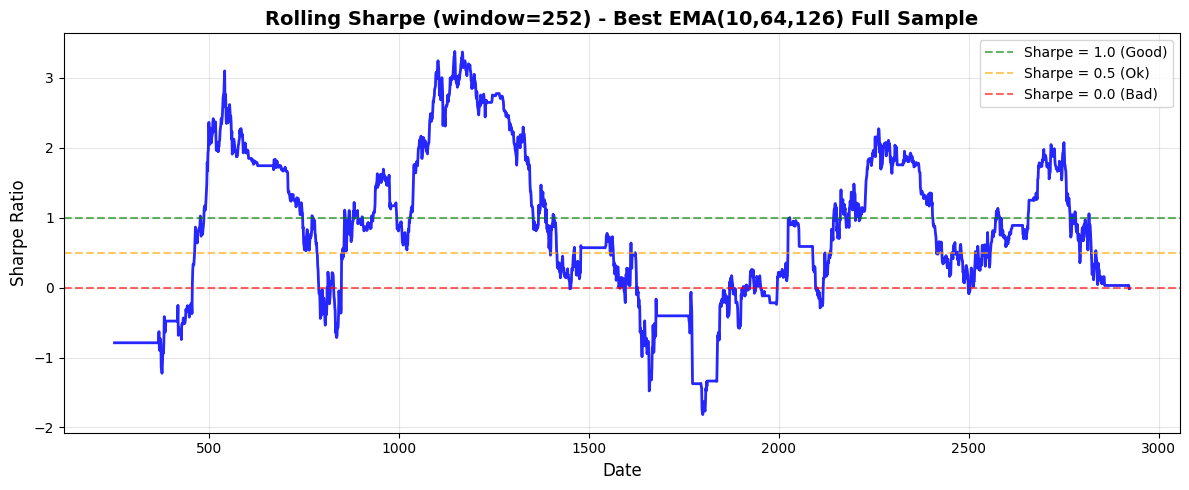

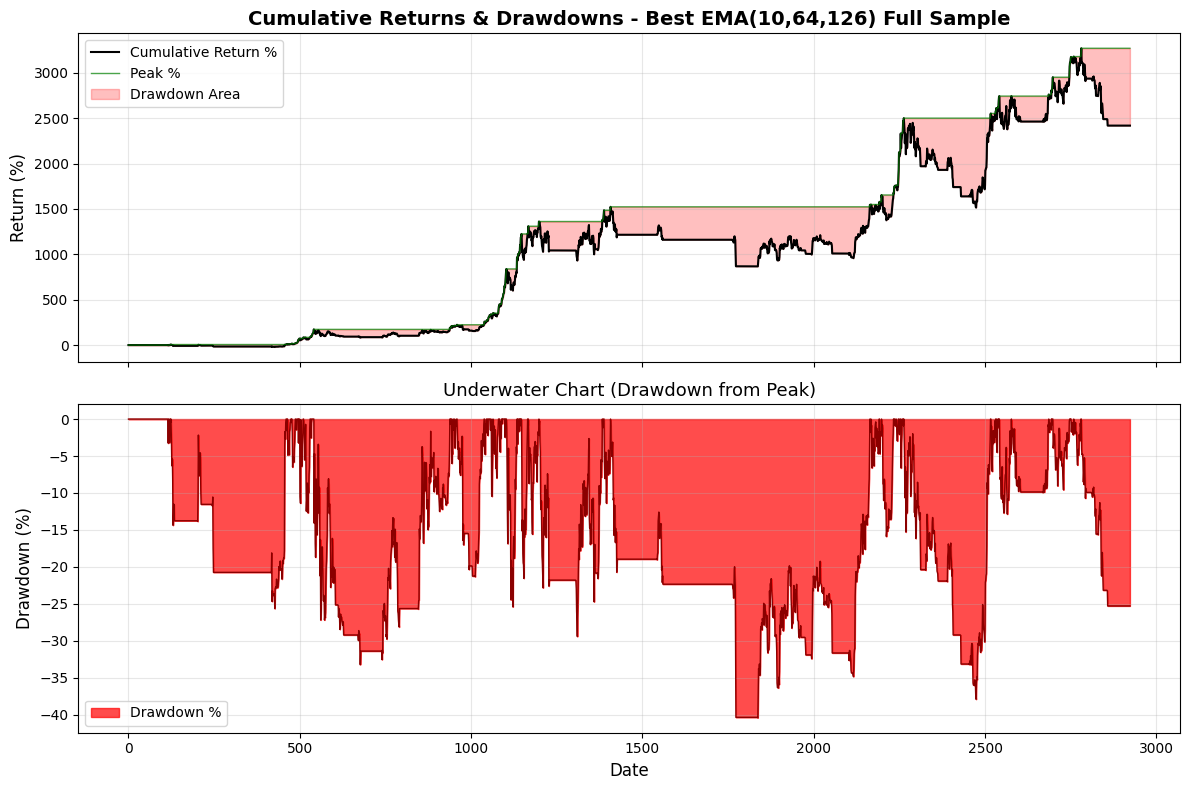

✅ Rolling Sharpe and Drawdown analysis complete for best strategy: EMA(10,64,126)


In [20]:
#Full-Sample evaluation
#SECOND SANITY CHECK

# --- FULL-SAMPLE ROLLING SHARPE + DRAWDOWNS - BEST STRATEGY ---

if results_df.empty:
    print("No results to visualize.")
else:
    # 1. GET THE BEST STRATEGY
    # Retrieve the row with the highest Sharpe Ratio from the grid search results.
    best = results_df.loc[results_df['sharpe_ratio'].idxmax()]
    
    # Extract the winning EMA periods (convert to integers)
    ema1, ema2, ema3 = int(best['ema1_period']), int(best['ema2_period']), int(best['ema3_period'])

    # 2. BUILD INDICATORS ON FULL DATASET
    # We use 'close' (the entire dataset), not just 'train_close' or 'val_close'.
    ema1_full = vbt.MA.run(close, ema1, ewm=True).ma
    ema2_full = vbt.MA.run(close, ema2, ewm=True).ma
    ema3_full = vbt.MA.run(close, ema3, ewm=True).ma

    # 3. GENERATE TRIPLE EMA CROSSOVER SIGNALS
    # We calculate the individual crossovers for the entire history.
    # .reindex(close.index).fillna(False) ensures no dates are missing/NaN.
    entries_1 = ema1_full.vbt.crossed_above(ema2_full).reindex(close.index).fillna(False)
    entries_2 = ema1_full.vbt.crossed_above(ema3_full).reindex(close.index).fillna(False)
    entries_3 = ema2_full.vbt.crossed_above(ema3_full).reindex(close.index).fillna(False)
    
    # COMBINE ENTRIES (LOOSE LOGIC - Matches Grid Search Winner)
    # Uses '|' (OR) to buy if ANY crossover happens.
    entries_full = (entries_1 | entries_2 | entries_3).to_numpy(dtype=bool)

    # Calculate Exit Signals (Sell logic)
    exits_1 = ema1_full.vbt.crossed_below(ema2_full).reindex(close.index).fillna(False)
    exits_2 = ema1_full.vbt.crossed_below(ema3_full).reindex(close.index).fillna(False)
    exits_3 = ema2_full.vbt.crossed_below(ema3_full).reindex(close.index).fillna(False)
    
    # COMBINE EXITS (LOOSE LOGIC)
    # Uses '|' (OR) to sell if ANY crossover happens.
    exits_full = (exits_1 | exits_2 | exits_3).to_numpy(dtype=bool)

    # Prepare price data as a standard numpy array
    price_full = close.to_numpy(dtype=float)

    # 4. RUN THE FULL PORTFOLIO SIMULATION
    pf_full = vbt.Portfolio.from_signals(
        close=price_full,
        entries=entries_full,
        exits=exits_full,
        init_cash=100_000,
        fees=0.0005,      # 0.05% Fees
        slippage=0.0005,  # 0.05% Slippage
        freq=FREQ         # Ensure this matches your data frequency (e.g., '1D')
    )

    # 5. COMPUTE RETURNS
    # We extract the daily returns to plot the rolling metrics later.
    ret = pf_full.returns()
    
    print("Full-Sample Portfolio Ready for Visualization.")

    # --- VISUALIZATION: ROLLING SHARPE & DRAWDOWNS ---

    # 1) ROLLING SHARPE RATIO (252-day window)
    # shows the Sharpe ratio over time
    # checks if the strategy is degrading over time.

    # Define window size (approx 1 trading year = 252 days)
    # We use some min/max logic to ensure the window isn't bigger than the dataset itself.
    rolling_window = max(20, min(252, max(1, len(ret) // 4)))

    # Check if we have enough data to calculate it
    if len(ret) > rolling_window:
        # Calculate Rolling Sharpe using a standard formula:
        # (Average Daily Return * 252) / (Daily Volatility * sqrt(252))
        # We use a lambda function to apply this math to every rolling window.
        rolling_sharpe = ret.rolling(window=rolling_window).apply(
            lambda x: (x.mean() * 252) / (x.std() * np.sqrt(252)) if x.std() != 0 else np.nan,
            raw=False
        )

        # Plot the Rolling Sharpe
        plt.figure(figsize=(12, 5))
        plt.plot(rolling_sharpe.index, rolling_sharpe.values, linewidth=2, color='blue', alpha=0.85)
        
        # Add reference lines (Green=Good, Red=Bad)
        plt.axhline(y=1.0, color='green', linestyle='--', alpha=0.6, label='Sharpe = 1.0 (Good)')
        plt.axhline(y=0.5, color='orange', linestyle='--', alpha=0.6, label='Sharpe = 0.5 (Ok)')
        plt.axhline(y=0.0, color='red', linestyle='--', alpha=0.6, label='Sharpe = 0.0 (Bad)')
        
        plt.title(f'Rolling Sharpe (window={rolling_window}) - Best EMA({ema1},{ema2},{ema3}) Full Sample', fontsize=14, fontweight='bold')
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Sharpe Ratio', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()

    else:
        print("⚠️ Not enough data for rolling Sharpe calculation.")

    # 2) DRAWDOWNS (UNDERWATER CHART)
    # This visualizes the "Pain" of holding the strategy.
    # It calculates the percentage drop from the highest point (Peak) the portfolio has ever reached.

    # Calculate Cumulative Wealth Curve
    eq = (1 + ret).cumprod()
    # Calculate the "All-Time High" at every point
    peak = eq.cummax()
    # Calculate Drawdown %: (Current Value - Peak) / Peak
    dd = (eq - peak) / peak

    # Create a chart with 2 panels (Returns on top, Drawdown on bottom)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # --- TOP PANEL: Cumulative Return ---
    # We subtract 1 and multiply by 100 to convert "1.50" to "50%".
    ax1.plot(eq.index, (eq - 1) * 100, color='black', linewidth=1.5, label='Cumulative Return %')
    ax1.plot(peak.index, (peak - 1) * 100, color='green', linewidth=1.0, alpha=0.7, label='Peak %')

    # Fill the area between the Peak and Current Value to show "Lost Opportunity"
    ax1.fill_between(eq.index, (eq - 1) * 100, (peak - 1) * 100, color='red', alpha=0.25, label='Drawdown Area')

    ax1.set_title(f'Cumulative Returns & Drawdowns - Best EMA({ema1},{ema2},{ema3}) Full Sample', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Return (%)', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # --- BOTTOM PANEL: Underwater Plot ---
    # Fills the area from 0 down to the current drawdown level
    ax2.fill_between(dd.index, dd * 100, 0, color='red', alpha=0.7, label='Drawdown %')
    ax2.plot(dd.index, dd * 100, color='darkred', linewidth=1)

    ax2.set_title('Underwater Chart (Drawdown from Peak)', fontsize=13)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Drawdown (%)', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    plt.tight_layout()
    plt.show()

    print(f"✅ Rolling Sharpe and Drawdown analysis complete for best strategy: EMA({ema1},{ema2},{ema3})")

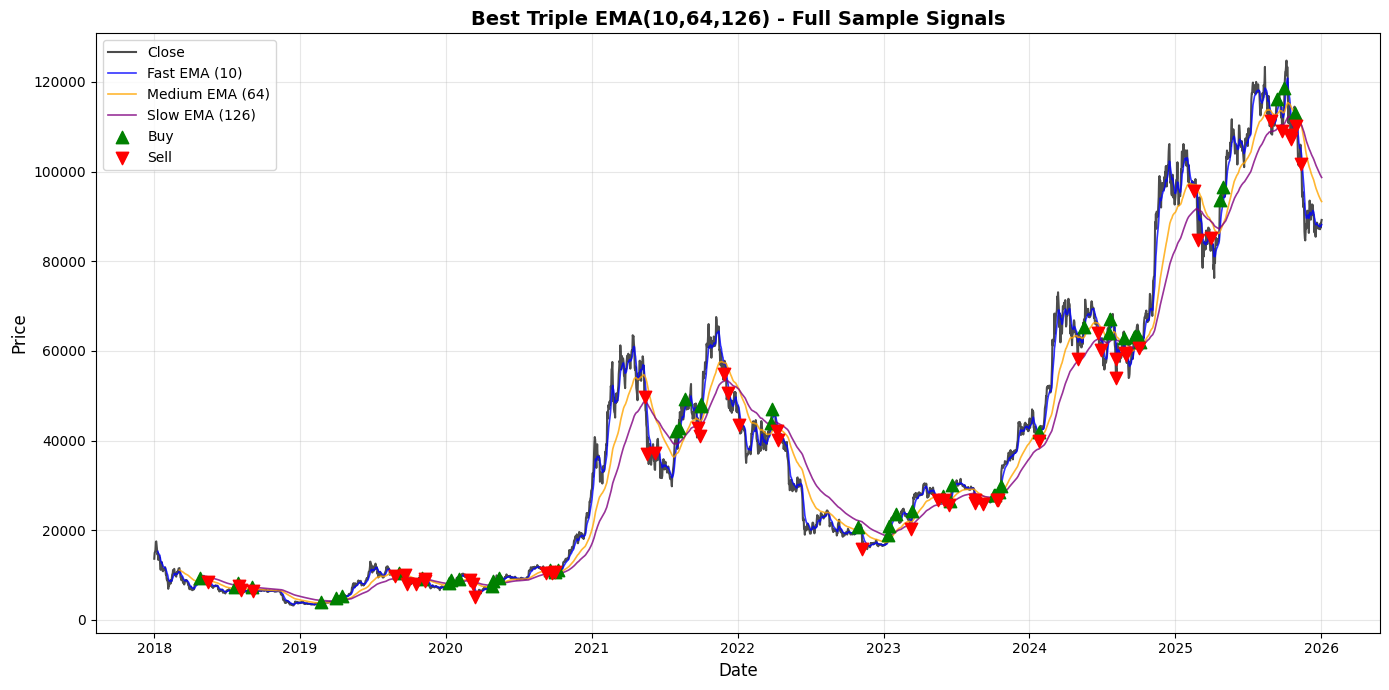

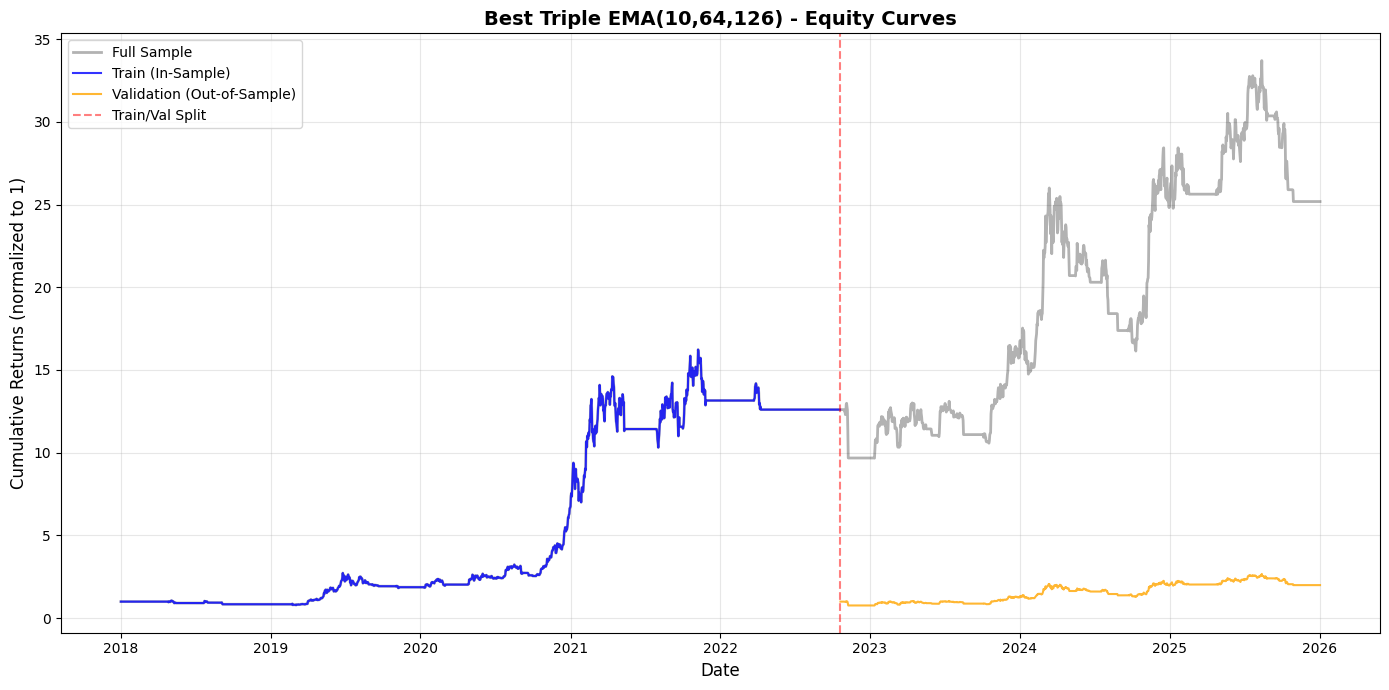

Visualizations complete for best strategy: EMA(10,64,126)


In [21]:
# --- STEP 5C: VISUALS ONLY (Signals + Equity Curves) - BEST STRATEGY ---

if results_df.empty:
    print("No results to visualize.")
else:
    # 1. GET BEST STRATEGY PARAMETERS
    best = results_df.loc[results_df['sharpe_ratio'].idxmax()]
    ema1, ema2, ema3 = int(best['ema1_period']), int(best['ema2_period']), int(best['ema3_period'])

    # 2. BUILD INDICATORS (FULL SAMPLE)
    ema1_full = vbt.MA.run(close, ema1, ewm=True).ma
    ema2_full = vbt.MA.run(close, ema2, ewm=True).ma
    ema3_full = vbt.MA.run(close, ema3, ewm=True).ma

    # 3. GENERATE SIGNALS (CONSISTENCY FIX: USING "LOOSE" LOGIC)
    # The image showed "Strict" logic here, but we switch to "Loose" (|)
    # to match your winning 1160% strategy.
    
    # Calculate individual crossovers
    c1 = ema1_full.vbt.crossed_above(ema2_full)
    c2 = ema1_full.vbt.crossed_above(ema3_full)
    c3 = ema2_full.vbt.crossed_above(ema3_full)
    
    # Combine with OR (|) for aggressive entry
    entries_full = (c1 | c2 | c3)

    # Calculate individual exits
    x1 = ema1_full.vbt.crossed_below(ema2_full)
    x2 = ema1_full.vbt.crossed_below(ema3_full)
    x3 = ema2_full.vbt.crossed_below(ema3_full)
    
    # Combine with OR (|) for fast exit
    exits_full = (x1 | x2 | x3)

    # Clean up signals (Fill NaNs and ensure format is correct for plotting)
    entries_full = entries_full.reindex(close.index).fillna(False).to_numpy(dtype=bool)
    exits_full = exits_full.reindex(close.index).fillna(False).to_numpy(dtype=bool)

    # --- PLOT 1: PRICE + EMAS + TRADE SIGNALS ---
    # This creates a big chart showing exactly where the bot traded.
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Plot Price
    ax.plot(close.index, close.values, label='Close', color='black', linewidth=1.5, alpha=0.7)
    
    # Plot the 3 EMAs
    ax.plot(close.index, ema1_full.values, label=f'Fast EMA ({ema1})', color='blue', alpha=0.8, linewidth=1.2)
    ax.plot(close.index, ema2_full.values, label=f'Medium EMA ({ema2})', color='orange', alpha=0.8, linewidth=1.2)
    ax.plot(close.index, ema3_full.values, label=f'Slow EMA ({ema3})', color='purple', alpha=0.8, linewidth=1.2)

    # Plot Buy Arrows (Green Up)
    buy_idx = close.index[entries_full]
    ax.scatter(buy_idx, close.reindex(buy_idx).values, marker='^', color='green', s=80, label='Buy', zorder=5)

    # Plot Sell Arrows (Red Down)
    sell_idx = close.index[exits_full]
    ax.scatter(sell_idx, close.reindex(sell_idx).values, marker='v', color='red', s=80, label='Sell', zorder=5)

    ax.set_title(f'Best Triple EMA({ema1},{ema2},{ema3}) - Full Sample Signals', fontsize=14, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Price', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best')
    plt.tight_layout()
    plt.show()

    # --- PREPARE DATA FOR EQUITY CURVES (Train vs Val) ---
    # We split the signals back into "Training" and "Validation" portions
    # so we can graph them separately in the next step.
    
    # Ensure split_idx exists (it should be defined in earlier cells)
    if 'split_idx' not in globals():
        split_idx = int(len(close) * 0.8) # Default fallback

    price_full = close.to_numpy(dtype=float)
    
    # Slice the arrays using the split index
    entries_train = entries_full[:split_idx]
    exits_train = exits_full[:split_idx]
    
    entries_val = entries_full[split_idx:]
    exits_val = exits_full[split_idx:]

    # Re-run the portfolio one last time to ensure 'pf_full' is fresh and correct
    pf_full = vbt.Portfolio.from_signals(
        close=price_full,
        entries=entries_full,
        exits=exits_full,
        init_cash=100_000,
        fees=0.0005,
        slippage=0.0005,
        freq=FREQ
    )
    
    # Training Portfolio
    # We build a portfolio specifically for the "In-Sample" (Training) period
    # to compare its growth curve against the Validation period later.
    pf_train = vbt.Portfolio.from_signals(
        close=train_close.to_numpy(dtype=float),
        entries=entries_train,
        exits=exits_train,
        init_cash=100_000,
        fees=0.0005,
        slippage=0.0005,
    freq=FREQ
)

# Validation Portfolio (pf_val2)
# We build a separate portfolio for the "Out-of-Sample" (Validation) period.
pf_val2 = vbt.Portfolio.from_signals(
    close=val_close.to_numpy(dtype=float),
    entries=entries_val,
    exits=exits_val,
    init_cash=100_000,
    fees=0.0005,
    slippage=0.0005,
    freq=FREQ
)

# --- CALCULATE EQUITY CURVES ---
# We convert daily returns into a "Growth Curve" (Cumulative Product).
# This shows how $1 grows over time for each period.
eq_full = (1 + pf_full.returns()).cumprod()
eq_train = (1 + pf_train.returns()).cumprod()
eq_val = (1 + pf_val2.returns()).cumprod()

# --- PLOT THE SPLIT ---
fig, ax = plt.subplots(figsize=(14, 7))

# 1. Plot the "Ghost" line (Full history in background)
ax.plot(close.index, eq_full.values, label='Full Sample', color='black', linewidth=2, alpha=0.3)

# 2. Plot Training Phase (Blue)
ax.plot(train_close.index, eq_train.values, label='Train (In-Sample)', color='blue', linewidth=1.5, alpha=0.8)

# 3. Plot Validation Phase (Orange)
# This is the moment of truth. Does the orange line keep going up?
ax.plot(val_close.index, eq_val.values, label='Validation (Out-of-Sample)', color='orange', linewidth=1.5, alpha=0.8)

# 4. Add the Vertical Split Line
# We draw a red line exactly where the Training data ends.
ax.axvline(x=train_close.index[-1], color='red', linestyle='--', alpha=0.5, label='Train/Val Split')

ax.set_title(f'Best Triple EMA({ema1},{ema2},{ema3}) - Equity Curves', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Cumulative Returns (normalized to 1)', fontsize=12)
ax.grid(True, alpha=0.3)
ax.legend(loc='best')
plt.tight_layout()
plt.show()

print(f"Visualizations complete for best strategy: EMA({ema1},{ema2},{ema3})")


Total trades plotted: 31
Win Rate: 45.2% (14W / 17L)
Avg Win: 51.53% | Avg Loss: -6.36%
Max Win: 348.61% | Max Loss: -23.21%


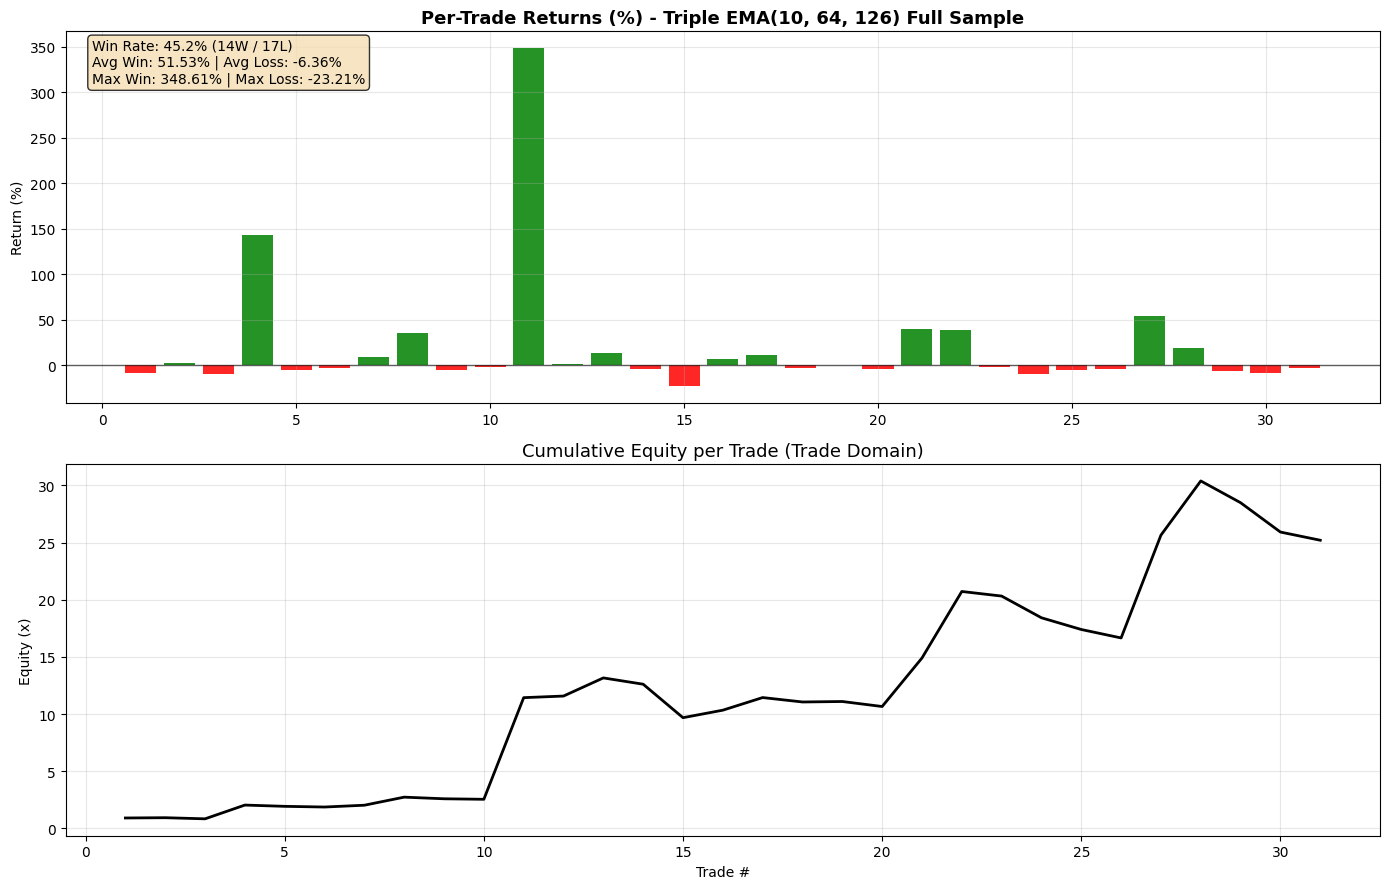

In [22]:
# STEP 5D: FULL-SAMPLE TRADE-BY-TRADE RETURNS (BAR) + CUMULATIVE PER-TRADE EQUITY - ALL TRADES

# --- Import Libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import vectorbt as vbt

# --- Default Configuration ---
# Check if a frequency variable 'FREQ' exists in the global scope.
# If not, default it to "1D" (1 Day).
if 'FREQ' not in globals():
    FREQ = "1D"

# --- Resolve Full Close Series ---
# This section attempts to locate the 'Close' price data, handling various 
# data structures (simple DataFrames vs MultiIndex DataFrames).

# Scenario A: Check if a variable named 'close' already exists and has an index.
if 'close' in globals() and hasattr(close, 'index'):
    full_close = close.astype(float)

# Scenario B: 'close' variable not found, look inside 'stock_data' DataFrame.
else:
    # Check if the DataFrame has Multi-level columns (e.g., from yfinance).
    if isinstance(stock_data.columns, pd.MultiIndex):
        
        # Method 1: Look for exact match of ('Close', TICKER).
        if ('Close', TICKER) in stock_data.columns:
            full_close = stock_data[('Close', TICKER)].astype(float).rename(TICKER)
        
        # Method 2: If exact match fails, search for the column manually.
        else:
            found = None
            for col in stock_data.columns:
                # Look for a tuple column name containing the word 'Close'
                if isinstance(col, tuple) and ('Close' in col):
                    found = col
                    break
            
            # Method 3: If still not found, search string representations of columns.
            if found is None:
                for col in stock_data.columns:
                    if 'Close' in str(col):
                        found = col
                        break
            
            # Error Handling: If absolutely no 'Close' column is found, stop execution.
            if found is None:
                raise KeyError("Could not find a 'Close' column for full-sample trade plot.")
            
            # Assign the found data to full_close
            full_close = stock_data[found].astype(float).rename(TICKER)

    # Scenario C: Simple DataFrame (single level columns).
    else:
        full_close = stock_data['Close'].astype(float).rename(TICKER)

# --- Best Parameters ---
# Ensure that 'results_df' (the output of previous grid search optimization) exists.
if 'results_df' not in globals() or results_df.empty:
    raise ValueError("results_df is empty or missing. Run the grid search first.")

# Find the row index with the highest Sharpe Ratio (a measure of risk-adjusted return).
# This identifies the "best" combination of parameters.
best = results_df.loc[results_df['sharpe_ratio'].idxmax()]

# Extract the specific EMA (Exponential Moving Average) periods from that "best" row.
# We convert them to integers because moving average windows must be whole numbers.
ema1, ema2, ema3 = int(best['ema1_period']), int(best['ema2_period']), int(best['ema3_period'])


# --- Indicators ---
# Calculate the three Moving Averages using the 'vectorbt' library (vbt).
# 'ewm=True' specifies that these are Exponential Moving Averages, not Simple ones.
ema1_full = vbt.MA.run(full_close, ema1, ewm=True)
ema2_full = vbt.MA.run(full_close, ema2, ewm=True)
ema3_full = vbt.MA.run(full_close, ema3, ewm=True)


# --- Signals ---
# (MATCH GRID SEARCH LOGIC - simple OR, no extra conditions)

# Entry Logic: Buy if ANY of the moving averages cross above another.
# The pipe symbol '|' represents the logical "OR" operator.
entries_raw = (
    ema1_full.ma_crossed_above(ema2_full.ma) |  # EMA1 crosses above EMA2
    ema1_full.ma_crossed_above(ema3_full.ma) |  # EMA1 crosses above EMA3
    ema2_full.ma_crossed_above(ema3_full.ma)    # EMA2 crosses above EMA3
)

# Exit Logic: Sell if ANY of the moving averages cross below another.
exits_raw = (
    ema1_full.ma_crossed_below(ema2_full.ma) |  # EMA1 crosses below EMA2
    ema1_full.ma_crossed_below(ema3_full.ma) |  # EMA1 crosses below EMA3
    ema2_full.ma_crossed_below(ema3_full.ma)    # EMA2 crosses below EMA3
)


# --- Convert to Plain Arrays ---
# Vectorbt signals can sometimes be complex objects. Here we flatten them into
# standard Pandas Series of booleans (True/False) to ensure they align perfectly
# with our price data index.
entries_full = pd.Series(np.asarray(entries_raw).ravel(), index=full_close.index, dtype=bool)
exits_full = pd.Series(np.asarray(exits_raw).ravel(), index=full_close.index, dtype=bool)


# --- Backtest ---
# Create a Portfolio simulation using the signals defined above.
pf_full = vbt.Portfolio.from_signals(
    close=full_close.to_numpy(dtype=float),  # The price data (converted to numpy array)
    entries=entries_full,                    # When to buy
    exits=exits_full,                        # When to sell
    init_cash=100_000,                       # Starting capital ($100,000)
    fees=0.0005,                             # Trading fee per trade (0.05%)
    slippage=0.0005,                         # Estimated price slippage per trade (0.05%)
    freq=FREQ                                # Time frequency (e.g., '1D' from previous step)
)

# --- Trade-by-trade returns (ALL trades) ---
trades = pf_full.trades

# robustly extract returns values, handling different data types (Series vs Array)
trade_returns = trades.returns.values if hasattr(trades.returns, 'values') else np.asarray(trades.returns)
trade_returns = np.asarray(trade_returns).ravel() # ensure 1D array

# Safety Check: Ensure there are actually trades to analyze
if trade_returns.size == 0:
    print("No trades to plot.")
else:
    # --- Calculate Statistics ---
    # Create masks for winning and losing trades
    winning_trades = trade_returns[trade_returns > 0]
    losing_trades = trade_returns[trade_returns < 0]

    # Basic counts
    total_trades = len(trade_returns)
    win_count = len(winning_trades)
    loss_count = len(losing_trades)
    
    # Calculate Win Rate (handle division by zero if no trades exist)
    win_rate = (win_count / total_trades * 100) if total_trades > 0 else 0

    # Calculate Average and Max percentages
    # We multiply by 100 to convert decimals (e.g., 0.05) to percentages (5.0)
    avg_win_pct = (winning_trades.mean() * 100) if len(winning_trades) > 0 else 0
    avg_loss_pct = (losing_trades.mean() * 100) if len(losing_trades) > 0 else 0
    max_win_pct = (winning_trades.max() * 100) if len(winning_trades) > 0 else 0
    max_loss_pct = (losing_trades.min() * 100) if len(losing_trades) > 0 else 0

    # Print the stats to the console
    print(f"Total trades plotted: {total_trades}")
    print(f"Win Rate: {win_rate:.1f}% ({win_count}W / {loss_count}L)")
    print(f"Avg Win: {avg_win_pct:.2f}% | Avg Loss: {avg_loss_pct:.2f}%")
    print(f"Max Win: {max_win_pct:.2f}% | Max Loss: {max_loss_pct:.2f}%")

    # --- Prepare Equity Curve ---
    # Calculate cumulative product to see how $1 grows over time based on these returns
    equity_per_trade = np.cumprod(1.0 + trade_returns)

    # --- Plotting ---
    # Create a figure with 2 subplots (stacked vertically)
    fig, axes = plt.subplots(2, 1, figsize=(14, 9), sharex=False)

    # Plot 1: Per-trade returns (Bar Chart)
    x = np.arange(1, trade_returns.size + 1)
    
    # Color coding: Green for profits, Red for losses
    colors = np.where(trade_returns >= 0, 'green', 'red')
    
    # Create the bar chart on the first subplot (axes[0])
    axes[0].bar(x, trade_returns * 100.0, color=colors, alpha=0.85, width=0.8)
    
    # Add a horizontal black line at 0 for visual reference
    axes[0].axhline(0, color='black', linewidth=1, alpha=0.6)

    stats_text = (
        f"Win Rate: {win_rate:.1f}% ({win_count}W / {loss_count}L)\n"
        f"Avg Win: {avg_win_pct:.2f}% | Avg Loss: {avg_loss_pct:.2f}%\n"
        f"Max Win: {max_win_pct:.2f}% | Max Loss: {max_loss_pct:.2f}%"
    )

    # Place the text box on the top-left of the first plot (axes[0]).
    # x=0.02, y=0.98 places it relative to the axes (0 to 1 scale).
    # transform=axes[0].transAxes ensures the position is relative to the chart box, not data values.
    axes[0].text(0.02, 0.98, stats_text, transform=axes[0].transAxes,
                fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8)) # 'wheat' is the background color

    # --- Formatting Plot 1 (Bar Chart) ---
    # Set the title dynamically using the EMA variables.
    axes[0].set_title(f"Per-Trade Returns (%) - Triple EMA({ema1}, {ema2}, {ema3}) Full Sample",
                    fontsize=13, fontweight='bold')
    axes[0].set_ylabel('Return (%)')
    axes[0].grid(True, alpha=0.3) # Add a subtle grid

    # --- Formatting Plot 2 (Equity Curve) ---
    # Plot the cumulative equity (how $1 grows) on the second subplot (axes[1]).
    axes[1].plot(x, equity_per_trade, color='black', linewidth=2)

    # Set titles and labels for the equity curve
    axes[1].set_title("Cumulative Equity per Trade (Trade Domain)", fontsize=13)
    axes[1].set_xlabel("Trade #")
    axes[1].set_ylabel("Equity (x)") # (x) denotes a multiple of starting capital
    axes[1].grid(True, alpha=0.3)

    # --- Final Display ---
    # Adjust layout to prevent overlapping labels and show the window.
    plt.tight_layout()
    plt.show()
        